## MSDS AI Capstone: Visual QUestion Answering on Chart Data
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

Images in the FigureQA dataset are comprised on five types of figures commonly found in analytical documents. Fifteen question types were selected for the dataset concerning quantitative attributes in relational global and one-vs-one contexts. These include properties like minimum and maximum, greater and less than, medians, curve roughness, and area under the curve (AUC). All questions in the training and validation sets have either a yes or no answer.

<div class="alert alert-block alert-info">
<b>The FigureQA dataset</b><br>
https://www.microsoft.com/en-us/research/project/figureqa-dataset/
    </div>

## Verify TensorFlow Version and Keras Version

In [ ]:
#downgrade tensorflow version so keras can be stable (he latets version which is 2.14.0 was not working well with keras - we should use 2.12.0)
#uncomment lines below to do so, then restart the run timee after and comemnt it out before re running this cell
#!pip install tensorflow==2.12.0 --ignore-installed --user

import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.12.0


In [ ]:
#import keras
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
print("Keras version: ", tf.keras.__version__)

Keras version:  2.12.0


## Imports

In [ ]:
import numpy as np
import pandas as pd
from packaging import version

import os

from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import nltk
nltk.download('punkt')
import re
import string
from nltk.tokenize import word_tokenize

import math
from itertools import permutations
from scipy.stats import rankdata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#package for OCR
!sudo apt install tesseract-ocr
!pip install pytesseract

#instal pytesseract
import pytesseract
import shutil
import imutils
import cv2
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

#if needed ot isntall to run code direcltly in jupyter notebook instead of google collab, follow thos instructiosn instead: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,006 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Mount Google Cloud Sotrage Bucket to Colab Environment

Follow the isntructions here: https://colab.research.google.com/notebooks/snippets/gcs.ipynb#scrollTo=X0WH8rvDBtiG

Decided to use a GCP bucket instead of google drive because the train data has 100K images, which crashed the Google Drive mount in Colab


First, open run the following commands in a code block. The code will return a link for you to log in as a gmail user, and copy an verification code to authenticate yourself.

In [ ]:
from google.colab import auth

auth.authenticate_user()

project_id = 'msds-ai-capstone-chart-vqa'
!gcloud config set project {project_id}

Updated property [core/project].


You can use Cloud Storage FUSE to mount a Cloud Storage location to access it directly as a local filesystem path.

Run the following commands to install gcsfuse.

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  27453      0 --:--:-- --:--:-- --:--:-- 27697
OK
20 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 5,558 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.2.0_amd64.deb ...
Unpacking gcsfuse (1.2.0) ...
Setting up 

In [ ]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "dynamic-chart-vqa-train-data"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"29/10/2023 12:49:29.929980","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /mnt/gs/dynamic-chart-vqa-train-data\n"}


In [ ]:
# Then you can access it like a local path.
!ls -lh {local_path}

total 0
drwxr-xr-x 1 root root 0 Oct 29 00:49 sample_train1
drwxr-xr-x 1 root root 0 Oct 29 00:49 train1
drwxr-xr-x 1 root root 0 Oct 29 00:49 validation1


## Format the training data

In [ ]:
#first, define objects to hold the train images and train
###### IMPORTANT: COMMENTED OUT THE LINES THAT USED TO REFER TO THE FILES IN G_DRIVE (DUE TO THE TIMEOUT ISSUE WITH COLAB AND G-DRIVE THAT OCCURED IN 2023)
###### INSTEAD WE HAVE BELOW A LINE THAT REFER TO THE FILES IN THE GOOGLE CLOUD STORAGE MOUNT THAT WE JUST CREATED BEFORE
###### IF THINGS CHANG< WE CAN COMMENT OUT THE LATER AND UNCOMMENT THE FORMER

# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data')
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data')


####### trainign images ############################
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_img = get_path('./train1/png')
#train_img = get_path('./dataset/train1/png')

##### training question and answer pairs #################
import json

with open('./train1/qa_pairs.json', 'r') as f:
#with open('./train1/qa_pairs.json', 'r') as f:
    train_qa = json.load(f)


#extract the imagge indices, question, and answers from the question & answer pair json file
train_image_indices,train_questions,train_question_ids,train_answers = zip(
                *((q['image_index'], q['question_string'], q['question_id'], q['answer'])
                  for q in train_qa['qa_pairs']))

#extract the chart type from the annotation.json file (note: this file is actually formatted as a list of dictionnaries and not as a json object so we need a different etract ethod)
from operator import itemgetter

with open('./train1/annotations.json', 'r') as g:
#with open('./train1/annotations.json', 'r') as g:
    train_chart_annotation = json.load(g)
train_chart_type = list(map(itemgetter('type'), train_chart_annotation))


#extract the label (i.e. color) names from the chart
#different way to access this depending on the chart type
keyChart_type1 = ['pie','line',"dot_line"]
keyChart_type2 = ['vbar_categorical','hbar_categorical']

train_label_name = []
result = []

for item in train_chart_annotation:
  if item['type'] in keyChart_type1:
    result = [i['name'] for i in item['models']]
    train_label_name.append(result)
  else:
    for i in item['models']:
      result = i.get('labels')
      train_label_name.append(result)


## A first table that will hold the questiona ns answer pairs along with figure name and index (duplicate row for each figure name/index since there are several questions-answers per figure)
# convert the question, answers, images names, chart type, and labels to numpy arrays
train_image_fnames = ['{}.png'.format(idx)
                              for idx in train_image_indices]
train_image_fnames = np.array(train_image_fnames)
train_questions = np.array(train_questions)
train_question_ids = np.array(train_question_ids)
train_image_indices = np.array(train_image_indices)
train_answers = np.array(train_answers)


## A secodn table that will hold the chart type and colors/labels by figure name and index (here each row is a unqiue figure anme and index) based on the annotation.text file
train_image_indices_unique = [i['image_index'] for i in train_chart_annotation]
train_image_indices_unique = np.array(train_image_indices_unique)
train_image_fnames_unique = ['{}.png'.format(idx)
                              for idx in train_image_indices_unique]
train_image_fnames_unique = np.array(train_image_fnames_unique)
train_chart_type = np.array(train_chart_type)
#train_label_name = np.array(train_label_name,dtype=object)
#train_label_name_arr = [np.array(i) for i in train_label_name]
#np.array(train_label_name_arr)

In [ ]:
#check all the images got unzipped (we should have 100,000)
len(train_img)

100000

In [ ]:
train_img[2]

'10.png'

In [ ]:
#save train unique image file names and chart type (inputs for the model chart type prediction model)  to JSON
import json

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# writing the data to file
with open('train_chart_type.json', 'w') as f:
    json.dump(train_chart_type, f,
                       cls=NumpyEncoder)


# writing the data to file
with open('train_image_fnames_unique.json', 'w') as f:
    json.dump(train_image_fnames_unique, f,
                       cls=NumpyEncoder)


## Format the Validation Data

In [ ]:
#first, define objects to hold the train images and train

# Change working directory
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data')
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data')

val_img = get_path('./validation1/png')
#val_img = get_path('./datasets/validation1/png')



##### validation question and answer pairs #################
import json

with open('./validation1/qa_pairs.json', 'r') as f:
#with open('./validation1/qa_pairs.json', 'r') as f:
    val_qa = json.load(f)

#extract the imagge indices, question, and answers from the question & answer pair json file
val_image_indices,val_questions,val_question_ids,val_answers = zip(
                *((q['image_index'], q['question_string'], q['question_id'], q['answer'])
                  for q in val_qa['qa_pairs']))

#extract the chart type from the annotation.json file (note: this file is actually formatted as a list of dictionnaries and not as a json object so we need a different etract ethod)
from operator import itemgetter

with open('./validation1/annotations.json', 'r') as g:
#with open('./validation1/annotations.json', 'r') as g:
    val_chart_annotation = json.load(g)
val_chart_type = list(map(itemgetter('type'), val_chart_annotation))


#extract the label (i.e. color) names from the chart
#different way to access this depending on the chart type
keyChart_type1 = ['pie','line',"dot_line"]
keyChart_type2 = ['vbar_categorical','hbar_categorical']

val_label_name = []
result = []

for item in val_chart_annotation:
  if item['type'] in keyChart_type1:
    result = [i['name'] for i in item['models']]
    val_label_name.append(result)
  else:
    for i in item['models']:
      result = i.get('labels')
      val_label_name.append(result)


## A first table that will hold the questiona ns answer pairs along with figure name and index (duplicate row for each figure name/index since there are several questions-answers per figure)
# convert the question, answers, images names, chart type, and labels to numpy arrays
val_image_fnames = ['{}.png'.format(idx)
                              for idx in val_image_indices]
val_image_fnames = np.array(val_image_fnames)
val_questions = np.array(val_questions)
val_question_ids = np.array(val_question_ids)
val_image_indices = np.array(val_image_indices)
val_answers = np.array(val_answers)


## A secodn table that will hold the chart type and colors/labels by figure name and index (here each row is a unqiue figure anme and index) based on the annotation.text file
val_image_indices_unique = [i['image_index'] for i in val_chart_annotation]
val_image_indices_unique = np.array(val_image_indices_unique)
val_image_fnames_unique = ['{}.png'.format(idx)
                              for idx in val_image_indices_unique]
val_image_fnames_unique = np.array(val_image_fnames_unique)
val_chart_type = np.array(val_chart_type)

In [ ]:
#check all the images got unzipped (we should have 20,000)
len(val_img)

20000

In [ ]:
#save val unique image file names and chart type (inputs for the model chart type prediction model)  to JSON
import json

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# writing the data to file
with open('val_chart_type.json', 'w') as f:
    json.dump(val_chart_type, f,
                       cls=NumpyEncoder)


# writing the data to file
with open('val_image_fnames_unique.json', 'w') as f:
    json.dump(val_image_fnames_unique, f,
                       cls=NumpyEncoder)


## Utility Functions for training data

In [ ]:
#create a list of unique color names
# we will delete them from the vocab for the final model, since they willget extracted via OCR instead

color_names = {x for l in train_label_name for x in l}

#how many colors are there?
lenght = len(color_names)
print("there are",lenght,"unique color names.")
print("Examples of values are")
(list(color_names))[:10] #print first 10 color names

there are 100 unique color names.
Examples of values are


['Pale Green',
 'Medium Purple',
 'Black',
 'Web Gray',
 'Medium Mint',
 'Gold',
 'Indigo',
 'Medium Turquoise',
 'Salmon',
 'Light Green']

In [ ]:
#split the multi-word colors in single words (ex: 'Light Blue' becomes 'Light' and 'Blue') so hat we can remove them from the global dictionnary (next cell)
color_name_list = list(color_names)
color_name_list

color_name_tokens = []
color_name_token = []

for i in range(0,len(color_name_list)):
  color_names_token = word_tokenize(color_name_list[i])
  color_name_tokens.append(color_names_token)

#flatten the token list
color_name_tokens = [item for sublist in color_name_tokens for item in sublist]
# convert to lower case
color_name_tokens = [w.lower() for w in color_name_tokens]
#online keep unique names
unique_color_name_tokens = list(dict.fromkeys(color_name_tokens))


unique_color_name_tokens

['pale',
 'green',
 'medium',
 'purple',
 'black',
 'web',
 'gray',
 'mint',
 'gold',
 'indigo',
 'turquoise',
 'salmon',
 'light',
 'peru',
 'seafoam',
 'crimson',
 'dark',
 'periwinkle',
 'orchid',
 'khaki',
 'olive',
 'dim',
 'midnight',
 'blue',
 'lime',
 'brown',
 'cadet',
 'sky',
 'steel',
 'aqua',
 'yellow',
 'violet',
 'deep',
 'pink',
 'red',
 'chocolate',
 'tan',
 'orange',
 'hot',
 'rosy',
 'magenta',
 'teal',
 'sienna',
 'cyan',
 'coral',
 'slate',
 'bubblegum',
 'burlywood',
 'chartreuse',
 'navy',
 'tomato',
 'firebrick',
 'rebecca',
 'maroon',
 'sandy',
 'lawn',
 'indian',
 'dodger',
 'drab',
 'saddle',
 'cornflower',
 'royal',
 'forest']

### Utilty Function for tokenizing training questions

In [ ]:
#utility function to tokenize the training questions

#first a tokenizer that will recobined speicifc single tokens together into a unique token (we do this for the color names thata re multi-words so that they are represented by 1 token only, which align with how they will get extracted via OCR from the charts)
tokenizer = nltk.tokenize.MWETokenizer()
tokenizer.add_mwe(('Blue', 'Violet'))
tokenizer.add_mwe(('Cadet', 'Blue'))
tokenizer.add_mwe(('Dark', 'Blue'))
tokenizer.add_mwe(('Dark', 'Cyan'))
tokenizer.add_mwe(('Dark', 'Gold'))
tokenizer.add_mwe(('Dark', 'Gray'))
tokenizer.add_mwe(('Dark', 'Green'))
tokenizer.add_mwe(('Dark', 'Khaki'))
tokenizer.add_mwe(('Dark', 'Magenta'))
tokenizer.add_mwe(('Dark', 'Olive'))
tokenizer.add_mwe(('Dark', 'Orange'))
tokenizer.add_mwe(('Dark', 'Orchid'))
tokenizer.add_mwe(('Dark', 'Periwinkle'))
tokenizer.add_mwe(('Dark', 'Red'))
tokenizer.add_mwe(('Dark', 'Salmon'))
tokenizer.add_mwe(('Dark', 'Seafoam'))
tokenizer.add_mwe(('Dark', 'Slate'))
tokenizer.add_mwe(('Dark', 'Turquoise'))
tokenizer.add_mwe(('Dark', 'Violet'))
tokenizer.add_mwe(('Deep', 'Pink'))
tokenizer.add_mwe(('Deep', 'Sky', 'Blue'))
tokenizer.add_mwe(('Dim', 'Gray'))
tokenizer.add_mwe(('Dodger', 'Blue'))
tokenizer.add_mwe(('Forest', 'Green'))
tokenizer.add_mwe(('Green', 'Yellow'))
tokenizer.add_mwe(('Hot', 'Pink'))
tokenizer.add_mwe(('Indian', 'Red'))
tokenizer.add_mwe(('Lawn', 'Green'))
tokenizer.add_mwe(('Light', 'Coral'))
tokenizer.add_mwe(('Light', 'Gold'))
tokenizer.add_mwe(('Light', 'Green'))
tokenizer.add_mwe(('Light', 'Salmon'))
tokenizer.add_mwe(('Light', 'Seafoam'))
tokenizer.add_mwe(('Light', 'Sky', 'Blue'))
tokenizer.add_mwe(('Light', 'Slate'))
tokenizer.add_mwe(('Lime', 'Green'))
tokenizer.add_mwe(('Medium', 'Aqua'))
tokenizer.add_mwe(('Medium', 'Blue'))
tokenizer.add_mwe(('Medium', 'Mint'))
tokenizer.add_mwe(('Medium', 'Orchid'))
tokenizer.add_mwe(('Medium', 'Periwinkle'))
tokenizer.add_mwe(('Medium', 'Purple'))
tokenizer.add_mwe(('Medium', 'Seafoam'))
tokenizer.add_mwe(('Medium', 'Turquoise'))
tokenizer.add_mwe(('Midnight', 'Blue'))
tokenizer.add_mwe(('Navy', 'Blue'))
tokenizer.add_mwe(('Olive', 'Drab'))
tokenizer.add_mwe(('Orange', 'Red'))
tokenizer.add_mwe(('Pale', 'Green'))
tokenizer.add_mwe(('Rebecca', 'Purple'))
tokenizer.add_mwe(('Rosy', 'Brown'))
tokenizer.add_mwe(('Royal', 'Blue'))
tokenizer.add_mwe(('Saddle', 'Brown'))
tokenizer.add_mwe(('Sandy', 'Brown'))
tokenizer.add_mwe(('Sky', 'Blue'))
tokenizer.add_mwe(('Steel', 'Blue'))
tokenizer.add_mwe(('Violet', 'Red'))
tokenizer.add_mwe(('Web', 'Gray'))
tokenizer.add_mwe(('Web', 'Green'))
tokenizer.add_mwe(('Web', 'Maroon'))
tokenizer.add_mwe(('Web', 'Purple'))
tokenizer.add_mwe(('Yellow', 'Green'))


#only to be used ona specific question (not all at once)
def tokenize_train_val_question(question):
  words = []
  results = []
  # split into words
  results = word_tokenize(question)
  words.append(results)

  #flatten the words nested list of list into a single list
  words = [item for sublist in words for item in sublist]

  #combine color names as one name (as they will be 1 object extracted via OCR)
  words = tokenizer.tokenize(words)

  # convert to lower case
  words = [w.lower() for w in words]

  # remove punctuation
  words = [w for w in words if w not in string.punctuation]

  return words

In [ ]:
#test
train_questions[0]
tokenize_train_val_question(train_questions[0])


['is', 'pale_green', 'the', 'minimum']

### Utility Function for Global Dictionnary

In [ ]:
#utility function to build global dictionnary on train data (with color name not present)

def build_dict(text):
  words = []
  results = []
  # split into words
  for i in range(0,len(text)):
    results = word_tokenize(text[i])
    words.append(results)

  #flatten the words nested list of list into a single list
  words = [item for sublist in words for item in sublist]

  # convert to lower case
  words = [w.lower() for w in words]

  # remove punctuation
  words = [w for w in words if w not in string.punctuation]

  #only keep unique words
  unique_words = list(dict.fromkeys(words))

  #remove color names
  unique_words_nocolor = [w for w in unique_words if w not in unique_color_name_tokens]

  #build indexed dictionnary (making the index start at 30 as we'll keep the 29 irst spots for the dynamic local dictionnary - asusmign there will not be more than 29 distinct labels in a given chart)
  global_vocab_dict = {k: v for v, k in enumerate(unique_words_nocolor,30)}

  return global_vocab_dict

#build global dictionnary
global_dictionnary = build_dict(train_questions)

then, build the global dictionnary

In [ ]:
#pritn global dictionnary
global_dictionnary

{'is': 30,
 'the': 31,
 'minimum': 32,
 'maximum': 33,
 'greater': 34,
 'than': 35,
 'less': 36,
 'high': 37,
 'median': 38,
 'low': 39,
 'does': 40,
 'have': 41,
 'area': 42,
 'under': 43,
 'curve': 44,
 'smoothest': 45,
 'roughest': 46,
 'lowest': 47,
 'value': 48,
 'highest': 49,
 'intersect': 50}

In [ ]:
#save dictionnary to the gcp bucket, do it under boththe train ad validation foldersjust in case

#save udner train
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

with open("global_dictionnary.txt", "w") as output:
    output.write(str(global_dictionnary))


#save udner validation
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open("global_dictionnary.txt", "w") as output:
    output.write(str(global_dictionnary))



## OCR-based Dynamic Local Dictionnary

Here we extract the label from the chart images and capture new chart-speciifc tokens this way (i.e. forming a local dynamic dictionnary).

We will use as the encoded value a number representing the relative ranking of each identified label comapred to the topleft corner of the image (i.e. based on the distance between the coordinates (0,0) and the (left,top) coordinare of eacg label. The lable the closest gets encoded as '1', the next one as '2', etc.

### First, the utility function for the train and validation datasets
(becaus we have to do some extar data manipulation to only extact the labels pertaining to the color names that are used in the trainign questions, oterwise we woudlnt have questions that match this OCR-genenrated dictionnary.

This is only required because of the fact that were not usng the training data in its original intended way

In [ ]:
#utility funtion to apply OCR and extract the color labels and their position
#may consider to apply grayscaling andother preprocessing techniques as a future enhancement: https://stackoverflow.com/questions/37745519/use-pytesseract-ocr-to-recognize-text-from-an-image

pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

# Change working directory to access the images in the GCS bucket mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/train1/png')


def extract_OCR_info(img_name):
  #intiiate variables
  text_combined = []
  x_combined = []
  y_combined = []
  x2_combined = []
  y2_combined = []
  #load image and apply pytesseract
  img = Image.open(img_name)
  data = pytesseract.image_to_data(img, output_type='dict')
  boxes = len(data['level'])
  #extract text labels and x_y coordinates for each label
  for i in range(boxes):
    if data['text'][i].lower() in unique_color_name_tokens: #only keep the words in the image that matches colors (we only do this during training since we have torestructure the trainin data to accept OCR inputs)
      text_result = data['text'][i] #text label value obtained via OCR
      x_result = data['left'][i] #x-coordinate value of the top left corner of the bounding box for the text label
      y_result = data['top'][i] #y-coordinate value of the top left corner of the bounding box for the text label
      x2_result = x_result + data['width'][i] #the max x-coordinate value, based on the top left corner of the bounding box for the text label, plus the width ofthe box
      y2_result = y_result + data['height'][i] #the max y-coordinate value, based on the top left corner of the bounding box for the text label, plus the height of the box
      text_combined.append(text_result)
      x_combined.append(x_result)
      y_combined.append(y_result)
      x2_combined.append(x2_result)
      y2_combined.append(y2_result)
  x_y_combined = list(zip(x_combined,y_combined))
  x2_y2_combined = list(zip(x2_combined,y2_combined))
  return text_combined,x_y_combined,x2_y2_combined,x_combined,y_combined,x2_combined,y2_combined
      #result = i.get('labels')
      #train_label_name.append(result)

#test it on image 0
#[0] will return the text value for each label, [1] will return the x-y coordinate of the top left corner of the bounding box for each label
#[2] wil return the x-y coordinate of the bottom right corner of the bounding box for each label
#[3] will return the min x coordinate, [5] the max x coordinate of each label
#[4] will return the min y coordinate, [6] the max y coordinate of each label
print(extract_OCR_info("98.png")[0])

['Sandy', 'Brown', 'Chocolate', 'Slate', 'Light', 'Salmon', 'Magenta']


In [ ]:
#another test
print(extract_OCR_info("740.png")[0])

['Dark', 'Gold', 'Seafoam', 'Medium', 'Orchid', 'Dark', 'Orange', 'Violet', 'Blue', 'Pale', 'Green']


In [ ]:
#another test
print(extract_OCR_info("0.png")[0])
print(extract_OCR_info("0.png")[1])
print(extract_OCR_info("0.png")[2])
print(extract_OCR_info("0.png")[3])
print(extract_OCR_info("0.png")[4])
print(extract_OCR_info("0.png")[5])
print(extract_OCR_info("0.png")[6])

['Dark', 'Salmon', 'Light', 'Green', 'Dark', 'Red', 'Pale', 'Green', 'Royal', 'Blue']
[(696, 298), (696, 329), (542, 292), (542, 325), (407, 298), (407, 329), (263, 298), (263, 324), (116, 298), (118, 333)]
[(705, 325), (705, 369), (570, 321), (570, 363), (416, 325), (416, 350), (272, 320), (271, 358), (127, 328), (127, 356)]
[696, 696, 542, 542, 407, 407, 263, 263, 116, 118]
[298, 329, 292, 325, 298, 329, 298, 324, 298, 333]
[705, 705, 570, 570, 416, 416, 272, 271, 127, 127]
[325, 369, 321, 363, 325, 350, 320, 358, 328, 356]


In [ ]:
#utility function to combine nearby text labels (ex: combine "light" and "yellow" as "light yellow") and return the local dictionnary
#modified from https://stackoverflow.com/questions/55593506/merge-the-bounding-boxes-near-by-into-one

from math import sqrt

pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

# Change working directory to access the images
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/train1/png')


#Distance definition  between text to be merge
dist_limit = 4

#Compute a Matrix similarity of distances bewteen 2 label bounding boxes
def calc_sim(text1_x,text1_x2,text1_y,text1_y2,text2_x,text2_x2,text2_y,text2_y2):
    x_dist = min(abs(text1_x-text2_x), abs(text1_x-text2_x2), abs(text1_x2-text2_x), abs(text1_x2-text2_x2)) #we keep the closest points only, by first checking the cloest x coordinates
    y_dist = min(abs(text1_y-text2_y), abs(text1_y-text2_y2), abs(text1_y2-text2_y), abs(text1_y2-text2_y2)) #we keep the closest points only, by tnow chekcing the closest y coordinates

    dist = sqrt((x_dist)^2 + (y_dist)^2) #calculate the distance bctewene the 2 cloest points form the 2 bounding boxes

    return dist

#Principal algorithm for merge text and ot return encoded value
def local_dynamic_dict(img):
  #initialize variables
    extract_OCR = extract_OCR_info(img)
    texts = extract_OCR[0]
    x_y_coordinate = extract_OCR[1] # the x y coordinates of the top left corner of the bounding boxes
    text_x = extract_OCR[3] # x coordinate of top left corner of bounding boxes
    text_x2 = extract_OCR[5] # y coordinate of top left corner of bounding boxes
    text_y = extract_OCR[4]  # x coordinare of top right corner of bb
    text_y2 = extract_OCR[6] # y coordinate of bottom left corner of bb
    new_text = [w.lower() for w in texts] # a placehodler list, which we will save the final combined color names. this has been lowercased
    new_x_y_coordinates =  x_y_coordinate.copy()
    distances = []
    idx_to_remove = []
  #start loop
    for i,j in permutations(list(range(0,len(texts))),2):
      if j > i: #to ensure that the labels are combined inthe right order (ex: Light Blue not Blue Light)
        # Evaluate if the distanc ebetween 2 labels' bounding boxes is less than disctance limit defined
        if calc_sim(text_x[i],text_x2[i],text_y[i],text_y2[i],text_x[j],text_x2[j],text_y[j],text_y2[j]) < dist_limit:
          #print(calc_sim(text_x[i],text_x2[i],text_y[i],text_y2[i],text_x[j],text_x2[j],text_y[j],text_y2[j]))
          #print(x_coord[i],x2_coord[i],y_coord[i],y2_coord[i], x_coord[j],x2_coord[j],y_coord[j],y2_coord[j])
        # if true, create a new text string whch joins the 2 text labels
          new_text[i] = texts[i].lower() + '_' + texts[j].lower()
          idx_to_remove.append(j) #index of the j text label values that we will need to remove after (because they are alreadt merged under the i+j labels)
          try:
              new_x_y_coordinates.remove(x_y_coordinate[j]) #drop the coordinate associated with label j so we retainthe corodinate from label i as the coordinate from the new i+j merged label
          except ValueError:
              pass  # do nothing!
    #filter out the redundant j text value from the final list
    final_text = [j for i,j in enumerate(new_text) if i not in idx_to_remove]
    #now give a number to each label based on how close/far it is from the point (0,0) on the chart
    for i in range(0,len(new_x_y_coordinates)):
      dist_from_origin = math.dist((0,0), new_x_y_coordinates[i]) #calcuulate distance from origin
      distances.append(dist_from_origin) #collect all distances for all labels
    encoded_value = rankdata(list(map(lambda x: x, distances)), method='ordinal') #apply ranking to return a integer based on how small the distance from origins are

    #combine OCR words and their index into dictionnary
    local_dict = {final_text[i]: encoded_value[i] for i in range(len(final_text))}

    return local_dict,final_text,new_x_y_coordinates,encoded_value




#test it on image 0
#[0]will return the local dictionnary
#[3] will return the encoded value for the dynamic local dictionnary. [2] will return the detailed xy coordinates, [1] will retuned the final text labels conbined as needed
print(local_dynamic_dict("0.png")[0])
print(local_dynamic_dict("0.png")[1])
print(local_dynamic_dict("0.png")[2])
print(local_dynamic_dict("0.png")[3])


{'dark_salmon': 5, 'light_green': 4, 'dark_red': 3, 'pale_green': 2, 'royal_blue': 1}
['dark_salmon', 'light_green', 'dark_red', 'pale_green', 'royal_blue']
[(696, 298), (542, 292), (407, 298), (263, 298), (116, 298)]
[5 4 3 2 1]


### Encode Train Questions

Combine local dictionnary extracted via OCR with global dictionnary to encode the training questions

In [ ]:
#doing a test

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')

global_dictionnary = build_dict(train_questions)
local_dictionnary = local_dynamic_dict("0.png")[0]
tokenized_quest = tokenize_train_val_question(train_questions[0])

#combine local nd global dictionnary
dictionnary = global_dictionnary | local_dictionnary

#then encode the question using the combined local + global dictionnary
for key, value in dictionnary.items():
  newlist=map(lambda x: dictionnary[x], tokenized_quest)
print(list(newlist))

[30, 2, 31, 32]


Then encoding the training questions by merging th elocal dictionnary withthe globaldictionnary (note the first cellbelow is an old function that was not computationally efficient as it would re runt he OCR extrcation for eac question instead ofjust once per image - keeping it for ref, but we will use the functions on the cells below it)

In [ ]:
def encode_train_questions(text):
  encoded_questions = []
  idx_questions_to_remove = []
  idx = 'x' #setting idex with a placeholder variable otherwise idx_questions_to_remove will return an error fo rth efirst fiew iteration where the idx = i logic doens tget triggered
  #build global dictionnary (static - only on train data)
  global_dictionnary = build_dict(train_questions)
  #iterate other each training question and chart
  for i in range(0,len(text)-1): ###THIS IS LIEKLY THE REASON WY I HAD MISISNG ENCODED QUESTION BEFORE _ SHOUDLNT SUBSTRACT MINUS ! HERE (TO BE TESTED)
    #generate the local dictionnary for the words from the charts (the local dictionanry is unique to each chart)
    img_name = train_image_fnames[i]
    local_dictionnary = local_dynamic_dict(img_name)[0]
    #combine local dictionnary with global dictionnary
    dictionnary = global_dictionnary | local_dictionnary
    #tokenize the question
    tokenized_question = tokenize_train_question(train_questions[i])
    #encode the tokenized question with the indexes from the combined dictionnary
    for key, value in dictionnary.items():
      try:
        newlist=map(lambda x: dictionnary[x], tokenized_question)
        newlist=list(newlist)
      except KeyError:
        idx = i #print the index of the questions we were not able to encode (because OCR failed to recognize the color name)
    encoded_questions.append(newlist)
    idx_questions_to_remove.append(idx)
    idx_questions_to_remove = list(set(idx_questions_to_remove)) #only kep the unique indexes

  return encoded_questions,idx_questions_to_remove

#encode_train_questions(text)[0] will return the encoded questions
#encode_train_questions(text)[1] will returnt he indexes of the questions to remove because they coudlnt be encoded


First, building the local dictionnaries (1 for each image)

In [ ]:
# Change working directory to access the images
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/validation1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')

def build_local_dictionnaries(list_image_names): #make sure to pass the list of unique image name here
  local_dictionnaries = []
  for i in list_image_names:
    #generate the local dictionnary for the words from the charts (the local dictionanry is unique to each chart)
    local_dictionnary = local_dynamic_dict(i)[0]
    local_dictionnaries.append(local_dictionnary)

  return local_dictionnaries

We break up the local ictionanry build in multiple parts as it led to crashes/very long training otherwise. W ewill train 20K images by 20K images, with each run taing 4-5hrs

In [ ]:
train_local_dictionnaries_1 = build_local_dictionnaries(train_image_fnames_unique[:20000])

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt1.txt", "w") as output:
    output.write(str(train_local_dictionnaries_1))

In [ ]:
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
train_local_dictionnaries_2 = build_local_dictionnaries(train_image_fnames_unique[20001:40000])

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt2.txt", "w") as output:
    output.write(str(train_local_dictionnaries_2))

In [ ]:
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
train_local_dictionnaries_3 = build_local_dictionnaries(train_image_fnames_unique[40001:60000])

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt3.txt", "w") as output:
    output.write(str(train_local_dictionnaries_3))

In [ ]:
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
train_local_dictionnaries_4 = build_local_dictionnaries(train_image_fnames_unique[60001:80000])

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt4.txt", "w") as output:
    output.write(str(train_local_dictionnaries_4))

In [ ]:
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')
train_local_dictionnaries_5 = build_local_dictionnaries(train_image_fnames_unique[80001:100000])

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt5.txt", "w") as output:
    output.write(str(train_local_dictionnaries_5))

In [ ]:
#realized we mistakenly skipped some images, so doing oCR extraction on them now

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')

train_local_dictionnaries_1_missing = [local_dynamic_dict("20000.png")[0]]
train_local_dictionnaries_2_missing = [local_dynamic_dict("40000.png")[0]]
train_local_dictionnaries_3_missing = [local_dynamic_dict("60000.png")[0]]
train_local_dictionnaries_4_missing = [local_dynamic_dict("80000.png")[0]]


## SAVE THE LOCAL DICTIONARIES
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


##SAVE AS TXT FILE
with open("train_local_dictionnaries_pt1_missing.txt", "w") as output:
    output.write(str(train_local_dictionnaries_1_missing))

with open("train_local_dictionnaries_pt2_missing.txt", "w") as output:
    output.write(str(train_local_dictionnaries_2_missing))

with open("train_local_dictionnaries_pt3_missing.txt", "w") as output:
    output.write(str(train_local_dictionnaries_3_missing))

with open("train_local_dictionnaries_pt4_missing.txt", "w") as output:
    output.write(str(train_local_dictionnaries_4_missing))


In [ ]:
# Nw conbining the 5 local dictionnaries as one large one
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

#open the txt files where we saved each and save their content
with open('train_local_dictionnaries_pt1.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt1 = eval(text)

with open('train_local_dictionnaries_pt2.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt2 = eval(text)

with open('train_local_dictionnaries_pt3.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt3 = eval(text)

with open('train_local_dictionnaries_pt4.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt4 = eval(text)

with open('train_local_dictionnaries_pt5.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt5 = eval(text)


with open('train_local_dictionnaries_pt1_missing.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt1_missing = eval(text)

with open('train_local_dictionnaries_pt2_missing.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt2_missing = eval(text)

with open('train_local_dictionnaries_pt3_missing.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt3_missing = eval(text)

with open('train_local_dictionnaries_pt4_missing.txt', 'r') as f:
    text = f.read()
    local_dictionnaries_pt4_missing = eval(text)


#cobine the lists of dictionnaries
train_local_dictionnaries = local_dictionnaries_pt1 + local_dictionnaries_pt1_missing + local_dictionnaries_pt2 + local_dictionnaries_pt2_missing + local_dictionnaries_pt3 + local_dictionnaries_pt3_missing + local_dictionnaries_pt4 + local_dictionnaries_pt4_missing + local_dictionnaries_pt5



Then encoded the trainign questions using the local dictionnaries and the global dictionnary


In [ ]:
# Change working directory to access the images
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/validation1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')

#You need to have the val_local_dictionnaries aned global_dictionnary build before running this!

def new_encode_train_questions(text):
  encoded_questions = []
  idx_questions_to_remove = []
  idx = 'x' #setting idex with a placeholder variable otherwise idx_questions_to_remove will return an error fo rth efirst fiew iteration where the idx = i logic doens tget triggered
  #build global dictionnary (static - only on train data)
  #global_dictionnary = build_dict(train_questions) --- no need to rerun this if we ran it before, save computing time
  #iterate other each training question and chart
  for i in range(0,len(text)-1):
    #find the rleevant local dictionnary
    img_name = train_image_fnames[i] #will return the png name attached to the question (ex: "1.png")
    img_idx = np.where(train_image_fnames_unique == img_name)[0][0] #return index of the png image in the val_image_fnames_unique array, which has the sae=me order as the local dictionnary
    local_dictionnary = train_local_dictionnaries[img_idx] #will return the local dictionnary for the png
    #combine local dictionnary with global dictionnary
    dictionnary = global_dictionnary | local_dictionnary
    #tokenize the question
    tokenized_question = tokenize_train_val_question(text[i])
    #encode the tokenized question with the indexes from the combined dictionnary
    for key, value in dictionnary.items():
      try:
        newlist=map(lambda x: dictionnary[x], tokenized_question)
        newlist=list(newlist)
      except KeyError:
        idx = i #print the index of the questions we were not able to encode (because OCR failed to recognize the color name)
    encoded_questions.append(newlist)
    idx_questions_to_remove.append(idx)
    idx_questions_to_remove = list(set(idx_questions_to_remove)) #only kep the unique indexes

  return encoded_questions,idx_questions_to_remove

#encode_train_questions(text)[0] will return the encoded questions
#encode_train_questions(text)[1] will returnt he indexes of the questions to remove because they coudlnt be encoded


In [ ]:
# Change working directory to where the images are (for the OCR extracted-local dictionany function to work)
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/train1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1/png')

encoded_train_questions = new_encode_train_questions(train_questions)

In [ ]:
#replace the values that could not be encoded properly with "x"  so we can easily identify and remove them later on

encoded_train_clean =["x" if i in encoded_train_questions[1] else encoded_train_questions[0][i] for i in range(len(encoded_train_questions[0]))]

In [ ]:
#filter out the training questions we were not able to encode
encoded_train_list_filtered = [i for j,i in enumerate(encoded_train_questions[0]) if j not in encoded_train_questions[1]]

In [ ]:
len(encoded_train_list_filtered)

509478

In [ ]:
len(encoded_train_clean)

1327367

In [ ]:
#image name that had either importal or total OCR encoding questions errors (caused by fualty OCR)
#so that we cna rmeove them from oru training png folder later to avoid adding bias to our

train_images_to_remove = [i for j,i in enumerate(train_image_fnames) if j in encoded_train_questions[1]]


In [ ]:
import pandas as pd

df = pd.DataFrame(encoded_train_list_filtered)

## SAVE ENCODED QUESTIONS AS CSV FILE
# Change working directory to be where we want the saved encoded questions to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

# saving the dataframe
df.to_csv('encoded_train_questions.csv')

##SAVE ENCODED QUESTIONS AS TXT FILE
with open("encoded_train_questions.txt", "w") as output:
    output.write(str(encoded_train_list_filtered))

In [ ]:
df = pd.DataFrame(encoded_train_clean)

## SAVE ENCODED QUESTIONS (KEEP NON ENCODEABLE QUESTIONS IN THE LIST) AS CSV FILE
# Change working directory to be where we want the untarred files to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

# saving the dataframe
df.to_csv('encoded_train_questions_all.csv')

##SAVE ENCODED QUESTIONS AS TXT FILE
with open("encoded_train_questions_all.txt", "w") as output:
    output.write(str(encoded_train_clean))

In [ ]:
##SAVE THE ONDEX OF QUESTIONS TO RMEOVE AS TXT FILE, SO WE CAN USE IT FOR RMOVE THE ANSWER PAIRS
with open("index_of_training_questions-answers_to_remove.txt", "w") as output:
    output.write(str(encoded_train_questions[1]))

In [ ]:
##EXTRA COPY JUST IN CASE
with open("encoded_train_questions_notformatted.txt", "w") as output:
    output.write(str(encoded_train_questions[0]))

In [ ]:
# Change working directory to be where the saved   to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

with open("train_image_fnames_to_remove.txt", "w") as output:
    output.write(str(train_images_to_remove))

## Encode validation questions

*NEW* Code starts here!

First build the local dictionnary for each image

In [ ]:
# Change working directory to access the images
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/validation1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')

def build_local_dictionnaries(list_image_names): #make sure to pass the list of unique image name here
  local_dictionnaries = []
  for i in list_image_names:
    #generate the local dictionnary for the words from the charts (the local dictionanry is unique to each chart)
    local_dictionnary = local_dynamic_dict(i)[0]
    local_dictionnaries.append(local_dictionnary)

  return local_dictionnaries

In [ ]:
val_local_dictionnaries = build_local_dictionnaries(val_image_fnames_unique)

In [ ]:
## SAVE THE LOCAL DICTIONANRY
# Change working directory to be wwhere we want to save the file
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')


##SAVE AS TXT FILE
with open("val_local_dictionnaries.txt", "w") as output:
    output.write(str(val_local_dictionnaries))

Then, merge the global and local dictionnary to encode the questions based on which chart they tie back to

In [ ]:
# Change working directory to access the images
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/validation1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')

#You need to have the val_local_dictionnaries aned global_dictionnary build before running this!

def new_encode_val_questions(text):
  encoded_questions = []
  idx_questions_to_remove = []
  idx = 'x' #setting idex with a placeholder variable otherwise idx_questions_to_remove will return an error fo rth efirst fiew iteration where the idx = i logic doens tget triggered
  #build global dictionnary (static - only on train data)
  #global_dictionnary = build_dict(train_questions) --- no need to rerun this if we ran it before, save computing time
  #iterate other each training question and chart
  for i in range(0,len(text)-1):
    #find the rleevant local dictionnary
    img_name = val_image_fnames[i] #will return the png name attached to the question (ex: "1.png")
    img_idx = np.where(val_image_fnames_unique == img_name)[0][0] #return index of the png image in the val_image_fnames_unique array, which has the sae=me order as the local dictionnary
    local_dictionnary = val_local_dictionnaries[img_idx] #will return the local dictionnary for the png
    #combine local dictionnary with global dictionnary
    dictionnary = global_dictionnary | local_dictionnary
    #tokenize the question
    tokenized_question = tokenize_train_val_question(text[i])
    #encode the tokenized question with the indexes from the combined dictionnary
    for key, value in dictionnary.items():
      try:
        newlist=map(lambda x: dictionnary[x], tokenized_question)
        newlist=list(newlist)
      except KeyError:
        idx = i #print the index of the questions we were not able to encode (because OCR failed to recognize the color name)
    encoded_questions.append(newlist)
    idx_questions_to_remove.append(idx)
    idx_questions_to_remove = list(set(idx_questions_to_remove)) #only kep the unique indexes

  return encoded_questions,idx_questions_to_remove

#encode_train_questions(text)[0] will return the encoded questions
#encode_train_questions(text)[1] will returnt he indexes of the questions to remove because they coudlnt be encoded


In [ ]:
# Change working directory to where the images are (for the OCR extracted-local dictionany function to work)
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/validation1/png')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')

encoded_val_questions = new_encode_val_questions(val_questions)

In [ ]:
#filter out the val questions we were not able to encode
encoded_val_list_filtered = [i for j,i in enumerate(encoded_val_questions[0]) if j not in encoded_val_questions[1]]

In [ ]:
len(encoded_val_list_filtered)

102951

In [ ]:
len(encoded_val_questions[0])

265105

In [ ]:
#replace the values that could not be encoded properly with "x"  so we can easily identify and remove them later on

encoded_val_clean =["x" if i in encoded_val_questions[1] else encoded_val_questions[0][i] for i in range(len(encoded_val_questions[0]))]

In [ ]:
len(encoded_val_clean)

265105

Save the encoded questions and index of non-encodaeabe question to csv and txt files

In [ ]:
import pandas as pd

df = pd.DataFrame(encoded_val_list_filtered)

## SAVE ENCODED QUESTIONS (WITH NON ENCODEBLE REMOVED) AS CSV FILE
# Change working directory to be where we want the untarred files to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

# saving the dataframe
df.to_csv('encoded_val_questions.csv')

##SAVE ENCODED QUESTIONS AS TXT FILE
with open("encoded_val_questions.txt", "w") as output:
    output.write(str(encoded_val_list_filtered))

In [ ]:
df = pd.DataFrame(encoded_val_clean)

## SAVE ENCODED QUESTIONS (KEEP NON ENCODEABLE QUESTIONS IN THE LIST) AS CSV FILE
# Change working directory to be where we want the untarred files to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

# saving the dataframe
df.to_csv('encoded_val_questions_all.csv')

##SAVE ENCODED QUESTIONS AS TXT FILE
with open("encoded_val_questions_all.txt", "w") as output:
    output.write(str(encoded_val_clean))

In [ ]:
##SAVE THE ONDEX OF QUESTIONS TO RMEOVE AS TXT FILE, SO WE CAN USE IT FOR RMOVE THE ANSWER PAIRS
with open("index_of_val_questions-answers_to_remove.txt", "w") as output:
    output.write(str(encoded_val_questions[1]))

# FINAL FORMATTING

merge the encoded questions, heir answrs and the fnames array in one pandas dataframe table.

then remove the rows where the image indices matches the indicies that are to be rmeoved (because tey coudknt be endoed) - we obtained this output before and saved it udner the text files 'index_of_val_questions-answers_to_remove.txt' and 'index_of_train_questions-answers_to_remove.txt'

Then repeat the same for the validation data

### Validation data

In [ ]:
#load the saved encoded questions and index to remove files

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open('encoded_val_questions_all.txt', 'r') as f:
    text = f.read()
    encoded_val_questions = eval(text)


with open('index_of_val_questions-answers_to_remove.txt', 'r') as f:
    text = f.read()
    val_question_idx_to_remove = eval(text)


In [ ]:
#looks liek there is an error in the question encoding function and the last encoding question was issing
#necodingit here and adding it tothe full list
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')

val_local_dictionnaries_missing = local_dynamic_dict("19999.png")[0]
tokenized_quest = tokenize_train_val_question(val_questions[-1])

#combine local nd global dictionnary
dictionnary = global_dictionnary | val_local_dictionnaries_missing

#then encode the question using the combined local + global dictionnary
for key, value in dictionnary.items():
  missing_encoded_val_question=map(lambda x: dictionnary[x], tokenized_quest)

missing_encoded_val_question = list(missing_encoded_val_question)

#adding it to the list
encoded_val_questions = encoded_val_questions + [missing_encoded_val_question]

In [ ]:
#identify the image index associayed with at leats 1 question encoding failure (we forgot to do this for the validation data, it was already doen for the train data though)
val_images_to_remove = [i for j,i in enumerate(val_image_fnames) if j in val_question_idx_to_remove]

In [ ]:
#chekc firs 10 results
val_images_to_remove[:10]

['1.png',
 '1.png',
 '1.png',
 '1.png',
 '1.png',
 '1.png',
 '3.png',
 '3.png',
 '3.png',
 '3.png']

In [ ]:
#get the inque image index to remove
val_images_idx_to_remove_unique = np.unique(val_images_to_remove)

#check first 10 results
val_images_idx_to_remove_unique[:10]

array(['1.png', '10.png', '100.png', '1000.png', '10000.png', '10001.png',
       '10002.png', '10004.png', '10005.png', '10006.png'], dtype='<U9')

In [ ]:
#returnthe images names to keep that map to the questions and answers arrays
#this is what we will need ot use when callign the image generator to process the images later later
#we have mutipe quesitons ans answer for each image name so we need t make sure to keep this mapping correct here
val_images_fnames_to_keep = [i for i in val_image_fnames if i not in val_images_idx_to_remove_unique]

In [ ]:
val_images_fnames_to_keep[:10]

['0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png',
 '0.png']

In [ ]:
# Change working directory to be where the saved   to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open("val_image_fnames_to_keep.txt", "w") as output:
    output.write(str(val_images_fnames_to_keep))

In [ ]:
#how mnany validation images wont we be able to use? (out of 20K)
len(val_images_idx_to_remove_unique)

14486

In [ ]:
#index of the index of the final questiosn and answers we will be able to keep
val_images_fnames_to_keep_unique = np.unique(val_images_fnames_to_keep)
val_question_idx_to_keep = [j for j,i in enumerate(val_image_fnames) if i in val_images_fnames_to_keep_unique]

In [ ]:
#get the final list of encoded questions we're keeping
encoded_val_questions_final = [i for j,i in enumerate(encoded_val_questions) if j in val_question_idx_to_keep]

In [ ]:
#get the final list of non-encoded (i..e original natural language) questions we're keeping
#this will be useful for interpretation of reuslts later
val_questions_final = [i for j,i in enumerate(val_questions) if j in val_question_idx_to_keep]

In [ ]:
#get the final list of encoded answers we're keeping
encoded_val_answers_final = [i for j,i in enumerate(val_answers) if j in val_question_idx_to_keep]

In [ ]:
#pad the pad the encoded questiosn so they are all the same lenght as the longest one
max_question_lenght = len(max(encoded_val_questions_final, key=len))
encoded_val_questions_final = np.array([np.pad(row, (0, max_question_lenght-len(row))) for row in encoded_val_questions_final])

In [ ]:
#check the answers and question final list are the same lenght
len(encoded_val_questions_final)

65581

In [ ]:
#check the answers and question final list are the same lenght
len(encoded_val_answers_final)

65581

In [ ]:
#save the final endocded val questions and answers that can be used
# Change working directory to be where the saved   to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

with open("encoded_val_questions_final.txt", "w") as output:
    output.write(str(encoded_val_questions_final))

with open("encoded_val_answers_final.txt", "w") as output:
    output.write(str(encoded_val_answers_final))

In [ ]:
#save the final endocded val questions, answers and image fnames to keep  to JSON file
import json

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1')

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open('encoded_val_questions_final.json', 'w') as f:
    json.dump(encoded_val_questions_final, f,
                       cls=NumpyEncoder)

with open('encoded_val_answers_final.json', 'w') as f:
    json.dump(encoded_val_answers_final, f,
                       cls=NumpyEncoder)

with open('val_images_fnames_to_keep.json', 'w') as f:
    json.dump(val_images_fnames_to_keep, f,
                       cls=NumpyEncoder)

with open("val_questions_final.json", "w") as f:
    json.dump(val_questions_final, f,
                       cls=NumpyEncoder)

with open("val_questions_final.txt", "w") as output:
    output.write(str(val_questions_final))

# to read the json data back in, uncommeng the following code
#with open('encoded_val_questions_final.json') as f:
#    encoded_val_questions_final = np.asarray(json.load(f))

### now the same for the train data

In [ ]:
#load the saved encoded questions and index to remove files

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

with open('encoded_train_questions_all.txt', 'r') as f:
    text = f.read()
    encoded_train_questions = eval(text)


with open('train_image_fnames_to_remove.txt', 'r') as f:
    text = f.read()
    train_img_idx_to_remove = eval(text)

In [ ]:
#check the first 10 results
train_img_idx_to_remove[:10]

['3.png',
 '3.png',
 '3.png',
 '3.png',
 '3.png',
 '3.png',
 '3.png',
 '3.png',
 '5.png',
 '5.png']

In [ ]:
#get the unique image index to remove
train_images_idx_to_remove_unique = np.unique(train_img_idx_to_remove)

#check first 10 results
train_images_idx_to_remove_unique[:10]

array(['10.png', '100.png', '10000.png', '10002.png', '10003.png',
       '10006.png', '10007.png', '10008.png', '10011.png', '10012.png'],
      dtype='<U9')

In [ ]:
from tensorflow.python import train
#returnthe images names to keep that map to the questions and answers arrays
#this is what we will need ot use when callign the image generator to process the images later later
#we have mutipe quesitons ans answer for each image name so we need t make sure to keep this mapping correct here
train_images_fnames_to_keep = [i for i in train_image_fnames if i not in train_images_idx_to_remove_unique]



In [ ]:

# Change working directory to be where the saved   to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

with open("train_image_fnames_to_keep.txt", "w") as output:
    output.write(str(train_images_fnames_to_keep))

In [ ]:
#how mnany train images wont we be able to use? (out of 100K)
len(train_images_idx_to_remove_unique)

72906

In [ ]:
train_images_fnames_to_keep[-10:]

['99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png',
 '99995.png']

In [ ]:
#index of the index of the final questiosn and answers we will be able to keep
train_images_fnames_to_keep_unique = np.unique(train_images_fnames_to_keep)
train_question_idx_to_keep = [j for j,i in enumerate(train_image_fnames) if i in train_images_fnames_to_keep_unique]

In [ ]:
#get the final list of encoded questions we're keeping
encoded_train_questions_final = [i for j,i in enumerate(encoded_train_questions) if j in train_question_idx_to_keep]

#get the final list of encoded answers we're keeping
encoded_train_answers_final = [i for j,i in enumerate(train_answers) if j in train_question_idx_to_keep]

In [ ]:
#pad the pad the encoded questiosn so they are all the same lenght as the longest one
max_train_question_lenght = len(max(encoded_train_questions_final, key=len))
encoded_train_questions_final = np.array([np.pad(row, (0, max_train_question_lenght-len(row))) for row in encoded_train_questions_final])

In [ ]:
max_train_question_lenght

9

In [ ]:
encoded_train_questions_final

array([[30,  2, 31, ...,  0,  0,  0],
       [30,  3, 31, ...,  0,  0,  0],
       [30,  2, 34, ...,  0,  0,  0],
       ...,
       [30,  2, 36, ...,  0,  0,  0],
       [30,  1, 34, ...,  0,  0,  0],
       [40,  2, 50, ...,  0,  0,  0]])

In [ ]:
#check the answers and question final list are the same lenght
len(encoded_train_questions_final)

322642

In [ ]:
len(encoded_train_answers_final)

322642

In [ ]:
#save the final endocded val questions and answers that can be used
# Change working directory to be where the saved   to be
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone')
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

with open("encoded_train_questions_final.txt", "w") as output:
    output.write(str(encoded_train_questions_final))

with open("encoded_train_answers_final.txt", "w") as output:
    output.write(str(encoded_train_answers_final))

In [ ]:
#had issue where the encoded question file was so long that only the summary of the file was getting saved to TXT
#added this code before to fix this
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

with open("encoded_train_questions_final.txt", "w") as output:
    output.write(str(encoded_train_questions_final))

#reset threshold for print of numpy array back to default before summary is applied
numpy.set_printoptions(threshold=1000)

In [ ]:
#save final encoded train questions ot CSV

df = pd.DataFrame(encoded_train_questions_final)

# saving the dataframe
df.to_csv('encoded_train_questions_final.csv')

In [ ]:
#save final encoded train question ,answers and image fnames  to JSON
import json

os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# writing the data to file
with open('encoded_train_questions_final.json', 'w') as f:
    json.dump(encoded_train_questions_final, f,
                       cls=NumpyEncoder)

# writing the data to file
with open('encoded_train_answers_final.json', 'w') as f:
    json.dump(encoded_train_answers_final, f,
                       cls=NumpyEncoder)


# writing the data to file
with open('train_images_fnames_to_keep.json', 'w') as f:
    json.dump(train_images_fnames_to_keep, f,
                       cls=NumpyEncoder)

# to read the json data back in, uncommeng the following code
#with open('encoded_train_questions_final.json') as f:
#    encoded_train_questions_final = np.asarray(json.load(f))

## EDA on the Train data

In [ ]:
#explore directory and check how many images are in the training dataset
print(len(os.listdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')), "training images")

os.listdir("/mnt/gs/dynamic-chart-vqa-train-data/validation1")

20000 training images


['MSR Open Data Research License.pdf',
 'annotations.json',
 'annotations_format.txt',
 'png',
 'qa_pairs.json']

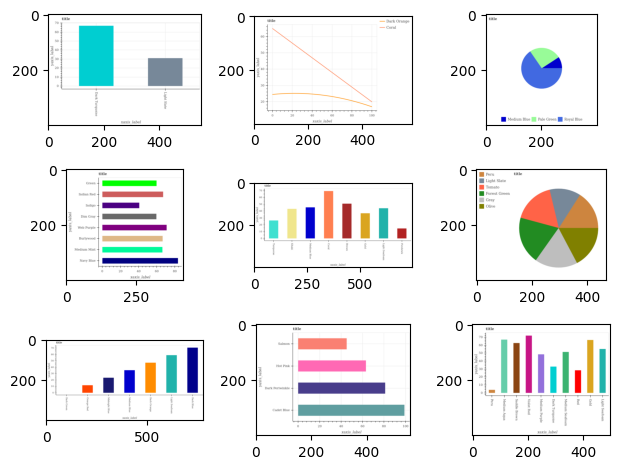

In [ ]:
#show a few different images

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Change working directory
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/validation1/png')
#os.chdir('/content/gdrive/MyDrive/NorthWestern University/Course/AI Capstone/Data/datasets/sample_train1/png')

#print 9 images
fig, axs = plt.subplots(3, 3)

row_counter=[0,1,2]
index = [0,100,200,300,400,500,600,700,800] #the index of the training pictures we're interested in displaying

#plot
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    image_name = str(index[i])+'.png'
    img = load_img(image_name)
    plt.imshow(img)

plt.tight_layout()
plt.show()

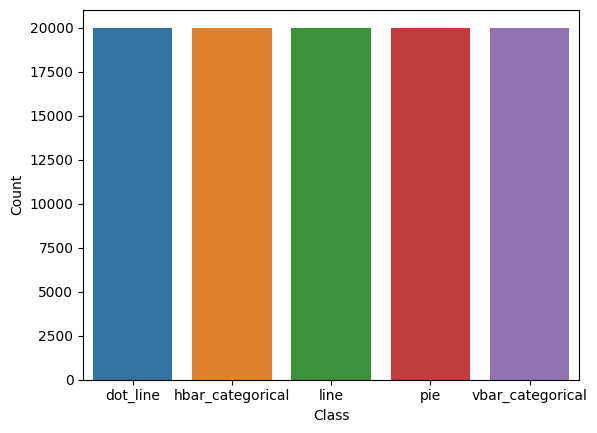

In [ ]:
#Frwquency of chart types in the train data
Class, Count = np.unique(train_chart_type, return_counts=True)
count_data = {'Class': Class, 'Count': Count}
distribution = pd.DataFrame(count_data).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);


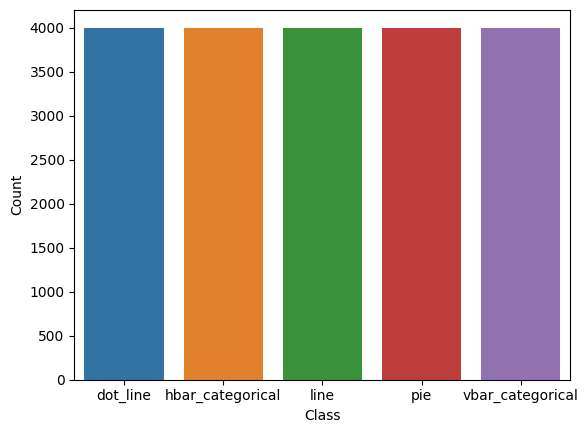

In [ ]:
#Frwquency of chart types in the val data
Class, Count = np.unique(train_chart_type, return_counts=True)
count_data = {'Class': Class, 'Count': Count}
distribution = pd.DataFrame(count_data).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);


## EDA on the Final train dataset we kept
Aka the images we kept after we removed images with failed OCR extraction / question encoding

In [ ]:
# load training data
import json
# Change working directory to the GCS mount
os.chdir('/mnt/gs/dynamic-chart-vqa-train-data/train1')


with open('train_images_fnames_to_keep.json') as f:
    train_images_fnames_to_keep = np.asarray(json.load(f))

In [ ]:
train_images_fnames_to_keep_unique = np.unique(train_images_fnames_to_keep)
train_chart_type_idx_to_keep = [j for j,i in enumerate(train_image_fnames_unique) if i in train_images_fnames_to_keep_unique]

In [ ]:
#get the final list of encoded questions we're keeping
train_chart_type_final = [i for j,i in enumerate(train_chart_type) if j in train_chart_type_idx_to_keep]

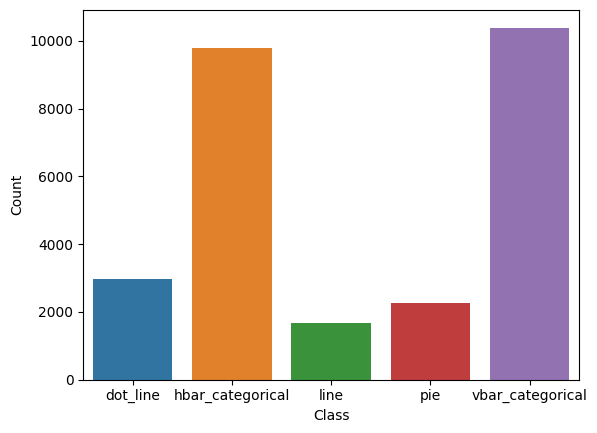

In [ ]:
#Frwquency of chart types in the train data, when we only look at images that we did not exclude (so, images where OCR extraction worked)
Class, Count = np.unique(train_chart_type_final, return_counts=True)
count_data = {'Class': Class, 'Count': Count}
distribution = pd.DataFrame(count_data).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

# Chart Classification Model

Training a model to be able to identify if a chart is a bar chart, pie chart of line chart (this is important for the production model because we need to e abel to generate relevant questions based ont he chart type)

In [ ]:
#check the size of our training inputs (they shoudl all be the same)
print('train_chart type_values:\t{}'.format(train_chart_type.shape))
print('train_images:\t{}'.format(train_image_fnames_unique.shape))
print('train_idx:\t{}'.format(train_image_indices_unique.shape))


train_chart type_values:	(1000,)
train_images:	(1000,)
train_idx:	(1000,)


### Model Validation Utility Functions

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')